In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import random
import seaborn as sns

from collections import Counter

In [62]:
def pre_processamento():
    xlsx = pd.ExcelFile('casos_corona.xlsx')
    df = pd.read_excel(xlsx, 'casos_corona')
    df = df[:5000] ################################limitando o dataset
    df = df[['bairroPaciente','municipioPaciente','resultadoFinalExame','sexoPaciente', 'idadePaciente']]
    
    novo_df = []
    for i in range(len(df)):
        if(df.loc[i][2] == 'Positivo'):
            resultado = 1
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
        else:
            resultado = 0
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
    
    novo_df = pd.DataFrame(novo_df)
    novo_df.rename(columns={0: 'bairro_paciente', 1: 'municipio_paciente', 2: 'resultado_exame', 3: 'sexo_paciente', 4: 'idade_paciente'}, inplace=True)    
    return novo_df

In [63]:
df = pre_processamento()
df

,bairro_paciente,municipio_paciente,resultado_exame,sexo_paciente,idade_paciente
0,VILA PERI,FORTALEZA,0,MASCULINO,74.0
1,VARJOTA,FORTALEZA,0,FEMININO,31.0
2,NOVA METROPOLE JUREMA,CAUCAIA,0,FEMININO,84.0
3,PARQUE POTIRA JUREMA,CAUCAIA,0,FEMININO,61.0
4,PINHEIRO,GUAIÚBA,0,MASCULINO,37.0
...,...,...,...,...,...
4995,SIQUEIRA,FORTALEZA,1,FEMININO,48.0
4996,CENTRO,CASCAVEL,1,FEMININO,71.0
4997,VILA VELHA,FORTALEZA,1,FEMININO,32.0
4998,JANGURUSSU,FORTALEZA,1,MASCULINO,91.0


In [64]:
def agrupar_idade(df):
    clusters_idades = []
    intervalos = np.arange(1, 100, dtype=int)
    for i in range(0, 95, 5):
        gaps = []
        for j in range(i, i+5):
            gaps.append(intervalos[j])
        clusters_idades.append(gaps)

    casos_idade = []

    for cluster in clusters_idades:
        count = 0
        for i in range(len(df)):
            if(df.loc[i][4] in cluster):
                count = count + 1
        casos_idade.append(['[{}:{}]'.format(cluster[0], cluster[4]), count])
    casos_idade = pd.DataFrame(casos_idade)
    casos_idade.rename(columns={0: 'idade', 1: 'count'}, inplace=True)
    casos_idade = casos_idade.sort_values(by=['count'], ascending=True)
    ordem = np.arange(1,len(casos_idade)+1)
    casos_idade['ordem'] = pd.Series(ordem, index=casos_idade.index)
    return casos_idade

In [65]:
dataset_idade = agrupar_idade(df)
dataset_idade

,idade,count,ordem
1,[6:10],31,1
18,[91:95],38,2
2,[11:15],50,3
0,[1:5],67,4
17,[86:90],75,5
16,[81:85],136,6
3,[16:20],142,7
15,[76:80],182,8
14,[71:75],199,9
13,[66:70],202,10


In [66]:
def top_k_reverse_idade(dataset, k):
    copia = dataset.copy()
    output = []
    for i in range(k):
        indice = copia['count'].idxmin()
        output.append([copia.loc[indice][0], copia.loc[indice][1]])
        copia.drop(indice, inplace=True,axis=0)
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'idade', 1: 'count'})
    return output

In [67]:
top_k_reverse_idade(dataset_idade, 10)

,idade,count
0,[6:10],31
1,[91:95],38
2,[11:15],50
3,[1:5],67
4,[86:90],75
5,[81:85],136
6,[16:20],142
7,[76:80],182
8,[71:75],199
9,[66:70],202


# Ruído de Laplace

In [68]:
def sensibilidade_lap(dataset, budget, k):
    smooth_functions = [1]*len(dataset['count'])
    beta = budget/k
    otimo = 0
    for smooth in smooth_functions:
        otimo = max(otimo, (smooth*math.exp(-beta)))
    return otimo

In [69]:
def plot_erros(erros_argumento, k):
    df = pd.DataFrame({
        'epsilon': ['0.1', '1', '3', '5', '8', '10'],
        'F1 Score': erros_argumento })
    sns.catplot(x="epsilon", y="F1 Score", palette="ch:.5",
                data=df, saturation=.7,
                kind="bar", ci=None, aspect=.9, order=['0.1', '1', '3', '5', '8', '10'])

    plt.xlabel("Epsilon")
    plt.ylabel("F1 Score, k = {}".format(k))
    return plt.show()

In [70]:
def f1_score(query, argumento_consulta, budgets):
    top = list(query)
    metrica_exponencial = []
    for argumento, budget in zip(argumento_consulta, budgets):
        falsos_positivos, falsos_negativos, verdadeiros_positivos = 0, 0, 0
        for i in range(len(argumento)):
            if(argumento[i] in top):
                if(argumento[i] == top[i]):
                    verdadeiros_positivos += 1
                else:
                    falsos_positivos += 1
            if(top[i] not in argumento):
                falsos_negativos += 1
            if(argumento[i] not in top):
                falsos_positivos += 1

        print("epsilon = {}:\nVerdadeiros Positivos: {}\nFalsos Positivos: {}\nFalsos Negativos: {}\n\n".format(budget, verdadeiros_positivos, falsos_positivos, falsos_negativos))

        precisao = verdadeiros_positivos/(verdadeiros_positivos + falsos_positivos) 
        revocacao = verdadeiros_positivos/(verdadeiros_positivos + falsos_negativos)

        f1_score = 2*((revocacao * precisao)/(revocacao + precisao))
        metrica_exponencial.append(f1_score)
    
    print(metrica_exponencial)

    return metrica_exponencial

# Consulta Idade com ruído

In [73]:
def laplace_idade(budget, sensibilidade, query, dataset, k):
    resposta_query = np.array(query['count'])
    coluna_idades = np.array(query['idade'])
    output = []
    np.random.seed(123)
    for i in range(k):
        ruido = stats.laplace.rvs(loc = 0, scale = sensibilidade/budget)
        output.append((resposta_query[i] + ruido))
    output = {
        'idade': coluna_idades,
        'count': output
    }
    
    df = pd.DataFrame(output, columns = ['idade', 'count'])
    return df.sort_values(by=['count'],ascending=True)

In [74]:
budgets = [0.1, 1, 3, 5, 8, 10]
idades = []
k = 10
for budget in budgets:
    a = laplace_idade(budget, sensibilidade_lap(dataset_idade, budget, 10), top_k_reverse_idade(dataset_idade, 10), dataset_idade, 10)
    a = np.array(a)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, a))
    idades.append(a[:,0])

epsilon: 0.1
reverse top-k:
[['[91:95]' 32.47424257442063]
 ['[6:10]' 35.94158586560154]
 ['[11:15]' 42.1755105787111]
 ['[1:5]' 68.07209032564536]
 ['[86:90]' 80.72173317485664]
 ['[81:85]' 134.34677249009792]
 ['[16:20]' 174.2541888949888]
 ['[76:80]' 186.56903140290578]
 ['[71:75]' 198.61504471201434]
 ['[66:70]' 199.59371840955]]


epsilon: 1
reverse top-k:
[['[6:10]' 31.451626942726875]
 ['[91:95]' 37.494983796651894]
 ['[11:15]' 49.284895510905926]
 ['[1:5]' 67.09798167820348]
 ['[86:90]' 75.52292703823024]
 ['[81:85]' 135.8489063822352]
 ['[16:20]' 144.94781090867593]
 ['[76:80]' 182.41757802855992]
 ['[71:75]' 198.96481773573748]
 ['[66:70]' 201.78008242139438]]


epsilon: 3
reverse top-k:
[['[6:10]' 31.123253622309694]
 ['[91:95]' 37.86217590117207]
 ['[11:15]' 49.80484065437152]
 ['[1:5]' 67.02674020439446]
 ['[86:90]' 75.1427121492717]
 ['[81:85]' 135.9587650028474]
 ['[16:20]' 142.8044878150639]
 ['[76:80]' 182.11396132459723]
 ['[71:75]' 198.99039839942844]
 ['[66:70]' 201

epsilon = 0.1:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 0


epsilon = 1:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


[0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0]


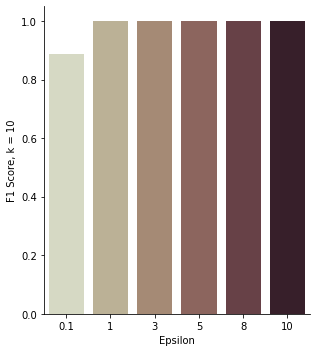

In [75]:
query_idades = top_k_reverse_idade(dataset_idade, 10)['idade']
f1_lap = f1_score(query_idades, idades, budgets)
plot_erros(f1_lap, 10)

# Mecanismo Exponencial

In [76]:
def score_function_exp(dataset):
    return -dataset['count']

In [77]:
def sensibilidade_exp(dataset, budget, k):
    smooth_functions = [1]*len(dataset['count'])
    beta = budget/k
    otimo = 0
    for smooth in smooth_functions:
        otimo = max(otimo, (smooth*math.exp(-beta)))
    return otimo

# Consulta Idade Exponencial

In [78]:
def exp_idades(budget, sensibilidade, dataset, k):
    budget = budget/k

    scores = score_function_exp(dataset)

    _users = list(dataset['idade'].copy())
    _scores = list(scores.copy())

    top = []

    for i_run in range(k):

        probabilities = []

        for j_score in _scores:
            probability = math.exp( (budget * j_score) / (2 * sensibilidade) )
            probabilities.append(probability)

        probabilities = [j_probability/sum(probabilities) for j_probability in probabilities]

        sample = random.choices(population=_users, weights=probabilities, k=1)[0]

        top.append(sample)

        _scores.remove(_scores[_users.index(sample)])
        _users.remove(sample)

    return top

In [83]:
idades_exp = []

for budget in budgets:
    b = exp_idades(budget, sensibilidade_exp(dataset_idade, budget, 10), dataset_idade, 10)
    b = np.array(b)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, b))
    idades_exp.append(b)

epsilon: 0.1
reverse top-k:
['[66:70]' '[91:95]' '[1:5]' '[6:10]' '[16:20]' '[76:80]' '[81:85]'
 '[11:15]' '[86:90]' '[56:60]']


epsilon: 1
reverse top-k:
['[91:95]' '[6:10]' '[11:15]' '[1:5]' '[16:20]' '[86:90]' '[81:85]'
 '[71:75]' '[76:80]' '[66:70]']


epsilon: 3
reverse top-k:
['[6:10]' '[91:95]' '[11:15]' '[1:5]' '[86:90]' '[81:85]' '[16:20]'
 '[76:80]' '[71:75]' '[66:70]']


epsilon: 5
reverse top-k:
['[6:10]' '[91:95]' '[11:15]' '[1:5]' '[86:90]' '[81:85]' '[16:20]'
 '[76:80]' '[66:70]' '[71:75]']


epsilon: 8
reverse top-k:
['[6:10]' '[91:95]' '[11:15]' '[1:5]' '[86:90]' '[81:85]' '[16:20]'
 '[76:80]' '[71:75]' '[66:70]']


epsilon: 10
reverse top-k:
['[6:10]' '[91:95]' '[11:15]' '[1:5]' '[86:90]' '[81:85]' '[16:20]'
 '[76:80]' '[71:75]' '[66:70]']




epsilon = 0.1:
Verdadeiros Positivos: 1
Falsos Positivos: 9
Falsos Negativos: 1


epsilon = 1:
Verdadeiros Positivos: 3
Falsos Positivos: 7
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


[0.16666666666666669, 0.4615384615384615, 1.0, 0.888888888888889, 1.0, 1.0]


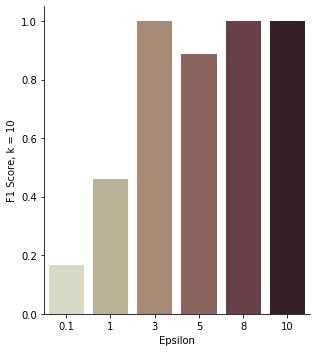

In [84]:
query_idades_exp = top_k_reverse_idade(dataset_idade, 10)['idade']
f1 = f1_score(query_idades_exp, idades_exp, budgets)
plot_erros(f1, 10)